In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Victor Hugo
### Ninety Three

In [2]:
BODY_START = 246
BODY_END = 17368
CHAP_PAT = r'^\s*(?:VOLUME|PART|BOOK|I|II|III|IV|V|VI|VII|VIII|IX|X|XI|XII|XIII|XIV|XV).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/Ninety_Three.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['PART I.\n',
 '\n',
 '\n',
 'AT SEA.\n',
 '\n',
 '\n',
 '[Illustration: The Forest of La Saudraie. 003]\n',
 '\n',
 '\n',
 '\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,PART I.\n
1,\n
2,\n
3,AT SEA.\n
4,\n


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 246,
    body_end = 17368,
    chap_pat = r'^\s*(?:VOLUME|PART|BOOK|I|II|III|IV|V|VI|VII|VIII|IX|X|XI|XII|XIII|XIV|XV).*$'
)
NT_K, NT_V = text_to_tokens(**cfg)

In [12]:
NT_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0           NN      PART     0    0     part   
                           1          PRP         I     0    0        i   
                           2            .         .     1    0      NaN   
         1        0        0          NNP        AT     0    0       at   
                           1          NNP       SEA     0    0      sea   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             7202  
                           1             5080  
                           2               -1  
         1        0        0              643  
                           1             8839

In [13]:
NT_K = NT_K.loc[NT_K.term_id >= 0]

In [14]:
NT_K.head()

pos     token_str  punc  num  \
chap_num para_num sent_num token_num                                 
0        0        0        0           NN          PART     0    0   
                           1          PRP             I     0    0   
         1        0        0          NNP            AT     0    0   
                           1          NNP           SEA     0    0   
         2        0        1           NN  Illustration     0    0   

                                          term_str  term_id  
chap_num para_num sent_num token_num                         
0        0        0        0                  part     7202  
                           1                     i     5080  
         1        0        0                    at      643  
                           1                   sea     8839  
         2        0        1          illustration     5115

In [15]:
NT_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,'adèle,1,0.000008,'adèl,0
1,'ah,2,0.000016,'ah,0
2,'all,1,0.000008,'all,0
3,'ami,1,0.000008,'ami,0
4,'athée,1,0.000008,'athé,0


In [16]:
WORDS = (NT_K.punc == 0) & (NT_K.num == 0) & NT_K.term_id.isin(NT_V[NT_V.stop==0].index)

In [17]:
BOW = NT_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,11161,11162,11163,11164,11165,11166,11167,11168,11169,11170
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * NT_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
NT_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / NT_V[NT_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,11161,11162,11163,11164,11165,11166,11167,11168,11169,11170
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.379102e-06,1.212745e-06,1.379102e-06,1.379102e-06,1.379102e-06,1.379102e-06,1.379102e-06,1.379102e-06,1.379102e-06,1.379102e-06,...,1.379102e-06,1.379102e-06,1.379102e-06,1.379102e-06,1.212745e-06,1.115433e-06,1.379102e-06,1.212745e-06,1.212745e-06,1.046388e-06
1,1.480065e-07,1.301529e-07,1.480065e-07,1.480065e-07,1.480065e-07,1.480065e-07,1.480065e-07,1.480065e-07,1.480065e-07,1.480065e-07,...,1.480065e-07,1.480065e-07,1.480065e-07,1.480065e-07,1.301529e-07,1.197093e-07,1.480065e-07,1.301529e-07,1.301529e-07,1.122994e-07
2,2.041820e-08,1.795522e-08,2.041820e-08,2.041820e-08,2.041820e-08,2.041820e-08,2.041820e-08,2.041820e-08,2.041820e-08,2.041820e-08,...,2.041820e-08,2.041820e-08,2.041820e-08,2.041820e-08,1.795522e-08,1.651446e-08,2.041820e-08,1.795522e-08,1.795522e-08,1.549223e-08
3,1.726685e-07,1.518401e-07,1.726685e-07,1.726685e-07,1.726685e-07,1.726685e-07,1.726685e-07,1.726685e-07,1.726685e-07,1.726685e-07,...,1.726685e-07,1.726685e-07,1.726685e-07,1.726685e-07,1.518401e-07,1.396562e-07,1.726685e-07,1.518401e-07,1.518401e-07,1.310116e-07
4,2.527359e-08,2.222491e-08,2.527359e-08,2.527359e-08,2.527359e-08,2.527359e-08,2.527359e-08,2.527359e-08,2.527359e-08,2.527359e-08,...,2.527359e-08,2.527359e-08,2.527359e-08,2.527359e-08,2.222491e-08,2.044155e-08,2.527359e-08,2.222491e-08,2.222491e-08,1.917623e-08


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,11161,11162,11163,11164,11165,11166,11167,11168,11169,11170
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.715169e-09,8.089131e-09,7.417789e-09,3.642848e-09,3.773984e-09,2.551838e-09,2.290145e-09,1.643811e-08,1.643811e-08,1.643811e-08,...,4.527917e-09,2.282165e-09,3.261793e-09,6.634539e-09,7.689142e-09,7.010800e-09,4.689514e-09,1.678489e-08,5.618369e-09,6.303871e-08
1,2.913944e-10,8.681331e-10,7.960840e-10,3.909539e-10,4.050274e-10,2.738656e-10,2.457804e-10,1.764153e-09,1.764153e-09,1.764153e-09,...,4.859403e-10,2.449241e-10,3.500586e-10,7.120249e-10,8.252059e-10,7.524056e-10,5.032830e-10,1.801370e-09,6.029686e-10,6.765373e-09
2,4.019925e-11,1.197631e-10,1.098236e-10,5.393394e-11,5.587546e-11,3.778107e-11,3.390658e-11,2.433733e-10,2.433733e-10,2.433733e-10,...,6.703777e-11,3.378844e-11,4.829225e-11,9.822721e-11,1.138411e-10,1.037979e-10,6.943028e-11,2.485076e-10,8.318239e-11,9.333153e-10
3,3.399489e-10,1.012788e-09,9.287338e-10,4.560977e-10,4.725163e-10,3.194993e-10,2.867343e-10,2.058110e-09,2.058110e-09,2.058110e-09,...,5.669115e-10,2.857353e-10,4.083882e-10,8.306681e-10,9.627082e-10,8.777773e-10,5.871440e-10,2.101529e-09,7.034400e-10,7.892672e-09
4,4.975850e-11,1.482424e-10,1.359393e-10,6.675926e-11,6.916247e-11,4.676528e-11,4.196946e-11,3.012467e-10,3.012467e-10,3.012467e-10,...,8.297914e-11,4.182323e-11,5.977600e-11,1.215853e-10,1.409121e-10,1.284807e-10,8.594058e-11,3.076019e-10,1.029629e-10,1.155255e-09


In [25]:
NT_V['tf_sum'] = TF.sum()
NT_V['tf_mean'] = TF.mean()
NT_V['tf_max'] = TF.max()
NT_V['tfidf_sum'] = TFIDF.sum()
NT_V['tfidf_mean'] = TFIDF.mean()
NT_V['tfidf_max'] = TFIDF.max()
NT_V['tfth_sum'] = TFTH.sum()
NT_V['tfth_mean'] = TFTH.mean()
NT_V['tfth_max'] = TFTH.max()
NT_V['th_sum'] = THM.sum()
NT_V['th_mean'] = THM.mean()
NT_V['th_max'] = THM.max()

In [26]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = NT_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [27]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,book,vendée,book,v,one,marquis,one,voice
1,one,v,v,deus,illustration,book,man,vendée
2,illustration,marquis,iii,dæmone,book,cimourdain,illustration,ii
3,v,convention,illustration,vendée,man,illustration,said,massacre
4,man,cimourdain,vendée,convention,said,convention,like,book
5,marquis,book,convention,marquis,like,one,would,iv
6,iii,dæmone,marquis,iii,cimourdain,vendée,gauvain,tellmarch
7,cimourdain,deus,cimourdain,æacus,would,man,men,bartholomew
8,said,iii,ii,provincial,gauvain,iii,book,france
9,convention,part,part,minos,marquis,'s,'s,saint


In [28]:
NT_V = NT_V[NT_V['stop'] == 0]

In [29]:
NT_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
0,'adèle,1,0.000008,'adèl,0,1.0,0.001756,0.000006,0.001739,0.014560,0.000047,0.014417,0.000029,9.158226e-08,0.000028,0.016321,0.000052,0.015943
1,'ah,2,0.000016,'ah,0,2.0,0.006018,0.000019,0.004975,0.043869,0.000140,0.036267,0.000293,9.348589e-07,0.000242,0.048625,0.000155,0.038063
2,'all,1,0.000008,'all,0,1.0,0.006005,0.000019,0.005988,0.049780,0.000159,0.049638,0.000268,8.554409e-07,0.000267,0.044590,0.000142,0.044211
3,'ami,1,0.000008,'ami,0,1.0,0.002505,0.000008,0.002487,0.020764,0.000066,0.020621,0.000055,1.752313e-07,0.000054,0.021898,0.000070,0.021520
4,'athée,1,0.000008,'athé,0,1.0,0.002615,0.000008,0.002597,0.021675,0.000069,0.021532,0.000059,1.895000e-07,0.000059,0.022686,0.000072,0.022308


In [30]:
D = get_docs(NT_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [31]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [32]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,part i at sea illustration the forest of la sa...,6,0.000096
1,book i the forest of la saudraie illustration ...,56,0.000895
2,vendée numbered nine hundred and twelve men ea...,406,0.006487
3,in less than a minute the spot where the movem...,48,0.000767
4,in the thickest part of the copse on the edge ...,328,0.005240


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

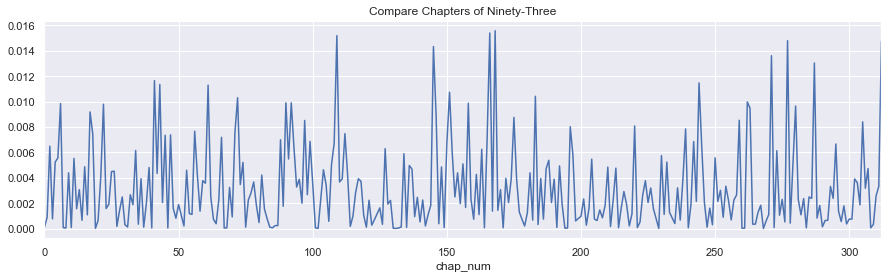

In [33]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of Ninety-Three')

In [34]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [35]:
NT_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
NT_P.index.names = ['doc_x','doc_y']

In [36]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [37]:
NT_P['euclidean'] = 0
NT_P['euclidean'] = NT_P.apply(euclidean, 1)

In [38]:
NT_PME = NT_P.euclidean.unstack().fillna(0)

In [39]:
NT_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
doc_x,,,,,,,,,,,,,,,,,,,,,
0,1.32415,1.356958,1.547526,1.406295,1.408957,1.395302,2.091718,2.838338,1.418126,2.645622,...,1.414990,1.453372,1.396156,1.423161,1.406423,2.588524,1.617711,1.431987,1.426157,1.383945
1,0.00000,0.672421,0.980134,0.738542,0.741187,0.707658,1.734177,2.573888,0.754010,2.359674,...,0.755146,0.817538,0.717525,0.766647,0.738628,2.295472,1.130717,0.795053,0.781286,0.693332
2,0.00000,0.000000,0.756806,0.424488,0.436586,0.378321,1.658692,2.502787,0.461251,2.281909,...,0.449379,0.560297,0.390216,0.475120,0.425942,2.215455,0.952037,0.512971,0.498047,0.337905
3,0.00000,0.000000,0.000000,0.737833,0.755242,0.728771,1.786238,2.588591,0.810251,2.375703,...,0.803348,0.869379,0.764583,0.816009,0.787461,2.311947,1.168582,0.841979,0.834119,0.738849
4,0.00000,0.000000,0.000000,0.000000,0.375793,0.344452,1.667967,2.509063,0.495383,2.288790,...,0.479633,0.587813,0.417504,0.503530,0.459534,2.221396,0.977210,0.543029,0.537354,0.384348


In [40]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [41]:
NT_P['cosine'] = NT_P.apply(cosine, 1)
NT_PMC = NT_P.cosine.unstack().fillna(0)
NT_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.0803,0.015347,0.000001,0.001642,0.001197,0.000189,0.026028,0.000002,0.000770,1.680363e-06,...,0.000001,9.859486e-07,0.000215,0.000001,0.000393,0.000002,1.510991e-02,0.002570,0.002328,0.000315
1,0.0000,0.008549,0.000352,0.001547,0.001592,0.001918,0.014264,0.000002,0.001935,9.970232e-07,...,0.000085,1.560206e-03,0.000549,0.000759,0.000483,0.000001,1.413259e-03,0.000705,0.001175,0.000661
2,0.0000,0.000000,0.003335,0.001918,0.001228,0.001416,0.000312,0.000002,0.001256,1.099859e-06,...,0.000906,7.020375e-04,0.000681,0.000820,0.000797,0.000001,2.623360e-03,0.001545,0.001232,0.001211
3,0.0000,0.000000,0.000000,0.010615,0.008005,0.007116,0.000001,0.000002,0.000568,1.033139e-06,...,0.000175,1.347387e-04,0.001223,0.000483,0.000629,0.000001,3.363324e-07,0.000580,0.000132,0.001853
4,0.0000,0.000000,0.000000,0.000000,0.010894,0.007996,0.000409,0.000002,0.001200,9.372191e-07,...,0.001361,7.275149e-04,0.001782,0.001296,0.001043,0.000611,6.521428e-04,0.001604,0.000307,0.001046


## Cosine Similarity

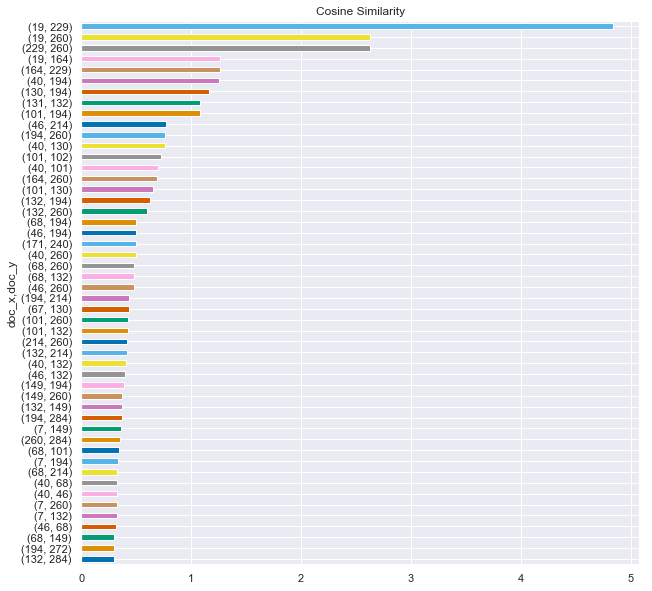

In [42]:
NT_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


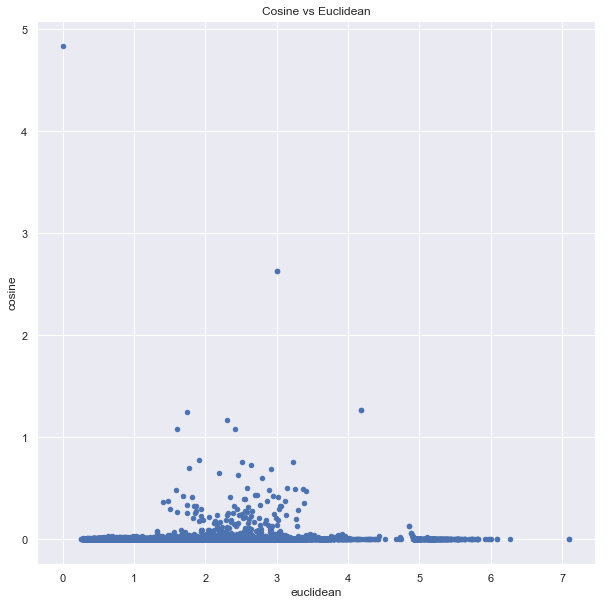

In [43]:
NT_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [44]:
import matplotlib.pyplot as plt

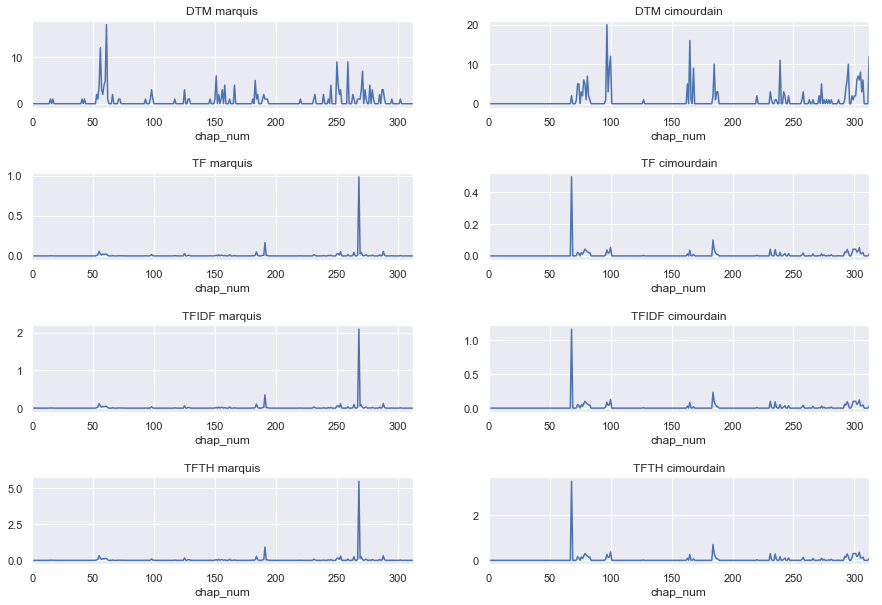

In [46]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('marquis cimourdain'.split()):
    W = get_term_id(NT_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

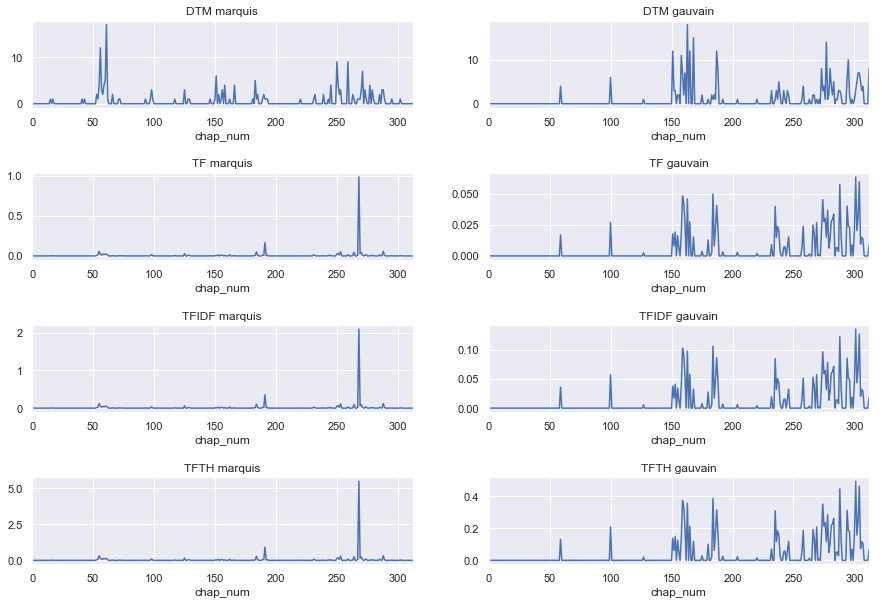

In [47]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('marquis gauvain'.split()):
    W = get_term_id(NT_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [48]:
NT_V.to_csv('Ninety_three_V.csv', index=False)

## Visualize KDE Plots

In [49]:
NT_K.head()

pos     token_str  punc  num  \
chap_num para_num sent_num token_num                                 
0        0        0        0           NN          PART     0    0   
                           1          PRP             I     0    0   
         1        0        0          NNP            AT     0    0   
                           1          NNP           SEA     0    0   
         2        0        1           NN  Illustration     0    0   

                                          term_str  term_id  
chap_num para_num sent_num token_num                         
0        0        0        0                  part     7202  
                           1                     i     5080  
         1        0        0                    at      643  
                           1                   sea     8839  
         2        0        1          illustration     5115

In [50]:
lmk = NT_K.copy()

In [51]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                       
0        0        0        0                  part     7202
                           1                     i     5080
         1        0        0                    at      643
                           1                   sea     8839
         2        0        1          illustration     5115

In [52]:
K = tt.reset_index()

In [53]:
K.rename_axis('offset', inplace=True)

In [54]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,part,i,at,sea,illustration,the,forest,of,la,saudraie,book
term_id,7202,5080,643,8839,5115,9972,4116,6942,5691,8745,1200


In [55]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [56]:
V1 = NT_V[(NT_V[vocab_weight] > NT_V[vocab_weight].quantile(vocab_weight_quantile)) & (NT_V.n >= vocab_min_n)]

In [57]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,1200,10576,5104,5115,10639,2291,6248,1852,5103,7202
term_str,book,v,iii,illustration,vendée,convention,marquis,cimourdain,ii,part
n,34,10,17,133,66,77,186,256,31,46
p,0.000270828,7.96553e-05,0.000135414,0.00105941,0.000525725,0.000613345,0.00148159,0.00203917,0.000246931,0.000366414
port_stem,book,v,iii,illustr,vendé,convent,marqui,cimourdain,ii,part
stop,0,0,0,0,0,0,0,0,0,0
df,27,10,17,103,36,39,72,62,28,39
tf_sum,3.98114,2.78263,1.79488,3.36261,1.55227,1.58492,2.06136,1.77622,1.16996,1.22022
tf_mean,0.0127193,0.0088902,0.00573445,0.0107432,0.00495933,0.00506363,0.00658581,0.00567483,0.0037379,0.00389846
tf_max,0.497223,0.988953,0.497223,0.332097,0.988953,0.988953,0.988953,0.498608,0.332097,0.497223
tfidf_sum,14.0738,13.8244,7.5431,5.39201,4.84323,4.76207,4.37027,4.14894,4.07458,3.66629


In [58]:
TOP_TERMS = NT_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [59]:
TOP_TERMS

['book',
 'v',
 'iii',
 'illustration',
 'vendée',
 'convention',
 'marquis',
 'cimourdain',
 'ii',
 'part',
 'deus',
 'dæmone',
 'iv',
 'ix',
 'gauvain',
 'bartholomew',
 'man',
 'one',
 'vi',
 'tellmarch',
 'mother',
 'halmalo',
 'said',
 'voice',
 'minos',
 'rhadamanthus',
 'æacus',
 'provincial',
 'vii',
 'would']

In [60]:
K = K[K.term_id.isin(V1.index)]

In [61]:
K.head(11).T

offset,0,3,4,6,8,9,10,13,15,16,17
term_str,part,sea,illustration,forest,la,saudraie,book,forest,la,saudraie,illustration
term_id,7202,8839,5115,4116,5691,8745,1200,4116,5691,8745,5115


In [62]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [63]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [64]:
B.head()

,offset,x
term_str,,
's,"[403, 939, 1122, 1127, 1337, 1414, 1673, 1712,...","[[403], [939], [1122], [1127], [1337], [1414],..."
abbé,"[18861, 26310, 33104, 41116, 41127, 41144, 564...","[[18861], [26310], [33104], [41116], [41127], ..."
action,"[8295, 9001, 11999, 13306, 31816, 67305, 69709...","[[8295], [9001], [11999], [13306], [31816], [6..."
added,"[1093, 1273, 1473, 1715, 4286, 6517, 7086, 718...","[[1093], [1273], [1473], [1715], [4286], [6517..."
advance,"[37160, 78422, 93026, 93074, 94258, 95508, 101...","[[37160], [78422], [93026], [93074], [94258], ..."


In [65]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [66]:
B.head()

,offset,x,kde,scores
term_str,,,,
's,"[403, 939, 1122, 1127, 1337, 1414, 1673, 1712,...","[[403], [939], [1122], [1127], [1337], [1414],...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.042155625339944, -12.026115249149118, -12..."
abbé,"[18861, 26310, 33104, 41116, 41127, 41144, 564...","[[18861], [26310], [33104], [41116], [41127], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-19.382896789953122, -19.28836510935563, -19...."
action,"[8295, 9001, 11999, 13306, 31816, 67305, 69709...","[[8295], [9001], [11999], [13306], [31816], [6...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.699696544744528, -12.653665156143449, -12..."
added,"[1093, 1273, 1473, 1715, 4286, 6517, 7086, 718...","[[1093], [1273], [1473], [1715], [4286], [6517...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-11.690527386537072, -11.673491984191497, -11..."
advance,"[37160, 78422, 93026, 93074, 94258, 95508, 101...","[[37160], [78422], [93026], [93074], [94258], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-39.13288526630074, -38.94642203804044, -38.7..."


In [67]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

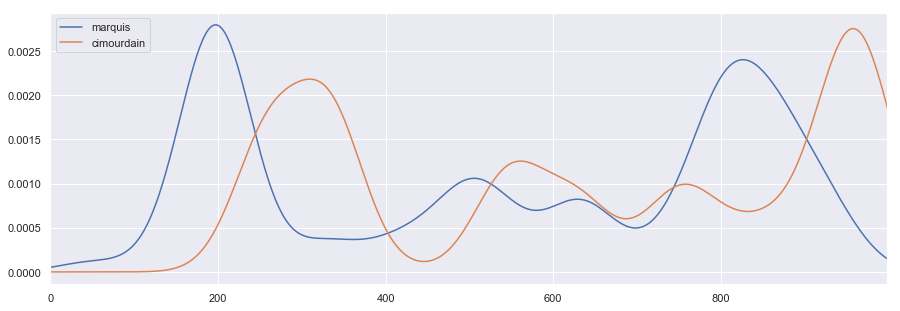

In [68]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['marquis'].plot(**FIG)
PLOTS.loc['cimourdain'].plot(**FIG)
plt.legend(loc='upper left') 

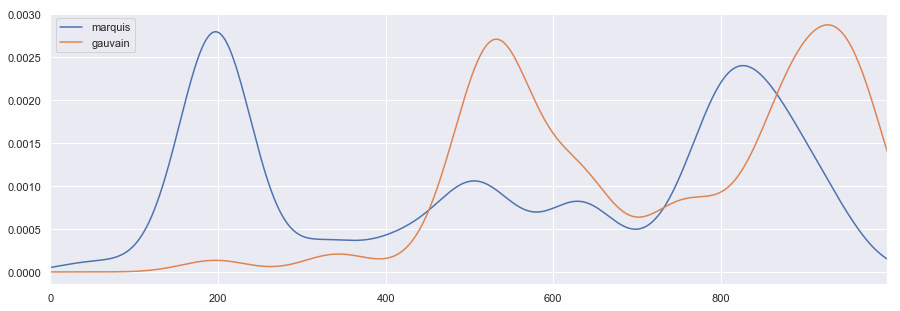

In [69]:
PLOTS.loc['marquis'].plot(**FIG)
PLOTS.loc['gauvain'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [70]:
WORDS = (NT_K.punc == 0) & (NT_K.num == 0) & NT_K.term_id.isin(NT_V[NT_V.stop==0].index)

In [71]:
BOW = NT_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [72]:
DTM = BOW.unstack().fillna(0)

In [73]:
alpha = .000001 
alpha_sum = alpha * NT_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [74]:
N_docs = DTM.shape[0]
NT_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / NT_V[NT_V.stop==0]['df'])

In [75]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,11161,11162,11163,11164,11165,11166,11167,11168,11169,11170
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.379132e-06,1.212771e-06,1.379132e-06,1.379132e-06,1.379132e-06,1.379132e-06,1.379132e-06,1.379132e-06,1.379132e-06,1.379132e-06,...,1.379132e-06,1.379132e-06,1.379132e-06,1.379132e-06,1.212771e-06,1.115457e-06,1.379132e-06,1.212771e-06,1.212771e-06,1.046411e-06
1,1.480069e-07,1.301532e-07,1.480069e-07,1.480069e-07,1.480069e-07,1.480069e-07,1.480069e-07,1.480069e-07,1.480069e-07,1.480069e-07,...,1.480069e-07,1.480069e-07,1.480069e-07,1.480069e-07,1.301532e-07,1.197095e-07,1.480069e-07,1.301532e-07,1.301532e-07,1.122996e-07
2,2.041821e-08,1.795522e-08,2.041821e-08,2.041821e-08,2.041821e-08,2.041821e-08,2.041821e-08,2.041821e-08,2.041821e-08,2.041821e-08,...,2.041821e-08,2.041821e-08,2.041821e-08,2.041821e-08,1.795522e-08,1.651447e-08,2.041821e-08,1.795522e-08,1.795522e-08,1.549224e-08
3,1.726690e-07,1.518405e-07,1.726690e-07,1.726690e-07,1.726690e-07,1.726690e-07,1.726690e-07,1.726690e-07,1.726690e-07,1.726690e-07,...,1.726690e-07,1.726690e-07,1.726690e-07,1.726690e-07,1.518405e-07,1.396565e-07,1.726690e-07,1.518405e-07,1.518405e-07,1.310119e-07
4,2.527360e-08,2.222492e-08,2.527360e-08,2.527360e-08,2.527360e-08,2.527360e-08,2.527360e-08,2.527360e-08,2.527360e-08,2.527360e-08,...,2.527360e-08,2.527360e-08,2.527360e-08,2.527360e-08,2.222492e-08,2.044156e-08,2.527360e-08,2.222492e-08,2.222492e-08,1.917624e-08


## Principal Component Analysis

In [76]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [77]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,-0.051462,-0.019949
1,-0.042722,-0.016609
2,-0.047700,-0.013568
3,-0.048133,-0.013716
4,-0.047994,-0.013824
5,-0.047978,-0.013830
6,-0.047761,-0.013609
7,0.015849,-0.047415
8,-0.053242,-0.017253
9,-0.047681,-0.013637


In [78]:
X = np.array(pca1)
X

array([[-5.14623170e-02, -1.99485060e-02],
       [-4.27215931e-02, -1.66092031e-02],
       [-4.76996120e-02, -1.35680375e-02],
       [-4.81329915e-02, -1.37164887e-02],
       [-4.79941493e-02, -1.38239135e-02],
       [-4.79780329e-02, -1.38298258e-02],
       [-4.77613867e-02, -1.36088788e-02],
       [ 1.58488400e-02, -4.74154087e-02],
       [-5.32416425e-02, -1.72531083e-02],
       [-4.76806865e-02, -1.36369903e-02],
       [-5.25589800e-02, -1.67121836e-02],
       [-4.76380648e-02, -1.35161947e-02],
       [-4.79079327e-02, -1.38753376e-02],
       [-4.78144689e-02, -1.37539604e-02],
       [-4.88034045e-02, -1.44317778e-02],
       [-4.78253159e-02, -1.40206710e-02],
       [-4.80319101e-02, -1.38163090e-02],
       [-4.78153941e-02, -1.35410405e-02],
       [-4.70662059e-02, -1.35555840e-02],
       [ 4.84043495e+00,  4.22401551e-02],
       [-4.81042862e-02, -1.39453765e-02],
       [-4.74379496e-02, -1.35014127e-02],
       [-4.77149875e-02, -1.34912185e-02],
       [-4.

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [80]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [81]:
print(pca.explained_variance_)

[0.17889219 0.08402737]


In [82]:
print(pca.mean_)

[3.58472570e-17 7.70926631e-18]


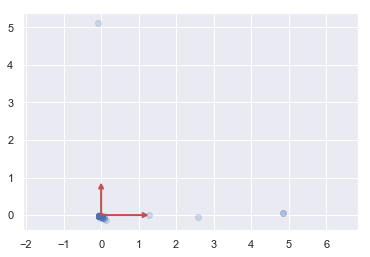

In [83]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [84]:
import sqlite3

In [85]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [86]:
text_db = 'db/Ninety_Three.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [87]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [88]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [89]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [90]:
emo_cols = combo.columns

In [91]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [92]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [93]:
tokens = tokens.join(combo, on='term_str', how='left')

In [94]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
230       13        1         14           NaN
163       15        1         19           NaN
148       4         7         19           1.0
283       2         3         14           NaN
262       15        1         51           NaN
295       44        1         13           NaN
17        44        2         10           NaN
11        1         4         0            NaN
216       1         1         32           NaN
163       8         2         17           NaN
Name: bing_sentiment, dtype: float64

In [95]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [96]:
tokens.head(10)

pos     token_str  punc  num  \
chap_num para_num sent_num token_num                                 
0        0        0        0           NN          PART     0    0   
                           1          PRP             I     0    0   
         1        0        0          NNP            AT     0    0   
                           1          NNP           SEA     0    0   
         2        0        1           NN  Illustration     0    0   
                           3           DT           The     0    0   
                           4          NNP        Forest     0    0   
                           5           IN            of     0    0   
                           6          NNP            La     0    0   
                           7          NNP      Saudraie     0    0   

                                          term_str  term_id  nrc_anger  \
chap_num para_num sent_num token_num                                     
0        0        0        0                  part     7146        0.0   
                           1                     i     5025        0.0   
         1        0        0                    at      591        0.0   
                           1                   sea     8787        0.0   
         2        0        1          illustration     5060        0.0   
                           3                   the     9922        0.0   
                           4                forest     4058        0.0   
                           5                    of     6881        0.0   
                           6                    la     5629        0.0   
                           7              saudraie     8693        0.0   

                                      nrc_anticipation  nrc_disgust  nrc_fear  \
chap_num para_num sent_num token_num                                            
0        0        0        0                       0.0          0.0       0.0   
                           1                       0.0          0.0       0.0   
         1        0        0                       0.0          0.0       0.0   
                           1                       0.0          0.0       0.0   
         2        0        1                       0.0          0.0       0.0   
                           3                       0.0          0.0       0.0   
                           4                       0.0          0.0       0.0   
                           5                       0.0          0.0       0.0   
                           6                       0.0          0.0       0.0   
                           7                       0.0          0.0       0.0   

                                      nrc_joy  nrc_negative  nrc_positive  \
chap_num para_num sent_num token_num                                        
0        0        0        0              0.0           0.0           0.0   
                           1              0.0           0.0           0.0   
         1        0        0              0.0           0.0           0.0   
                           1              0.0           0.0           0.0   
         2        0        1              0.0           0.0           0.0   
                           3              0.0           0.0           0.0   
                           4              0.0           0.0           0.0   
                           5              0.0           0.0           0.0   
                           6              0.0           0.0           0.0   
                           7              0.0           0.0           0.0   

                                      nrc_sadness  nrc_surprise  nrc_trust  \
chap_num para_num sent_num token_num                                         
0        0        0        0                  0.0           0.0        0.0   
                           1                  0.0           0.0        0.0   
         1        0        0                  0.0           0.0        0.0   
                    

In [97]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

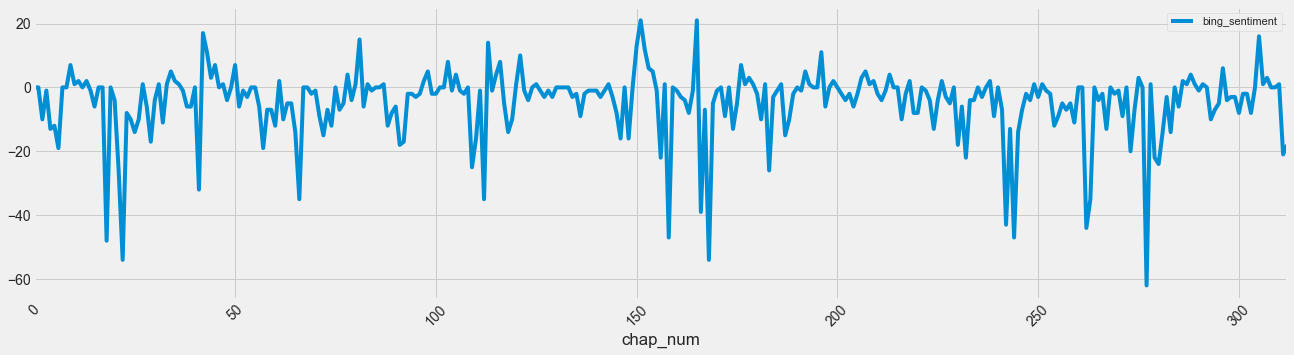

In [98]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [99]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [100]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [101]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0                    <span class='sent0'>PART</span>
                              1                       <span class='sent0'>I</span>
          1         0         0                      <span class='sent0'>AT</span>
                              1                     <span class='sent0'>SEA</span>
          2         0         1            <span class='sent0'>Illustration</span>
Name: html, dtype: object

In [102]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [103]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,part i at sea illustration the forest of la sa...,<span class='sent0'>PART</span> <span class='s...
1,book i the forest of la saudraie illustration ...,<span class='sent0'>BOOK</span> <span class='s...
2,vendée numbered nine hundred and twelve men ea...,<span class='sent0'>Vendée</span> <span class=...
3,in less than a minute the spot where the movem...,<span class='sent0'>In</span> <span class='sen...
4,in the thickest part of the copse on the edge ...,<span class='sent0'>In</span> <span class='sen...


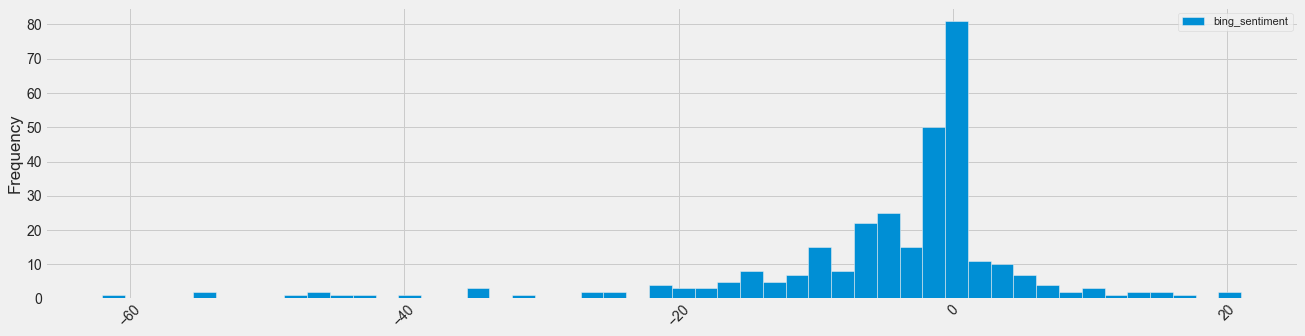

In [104]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [105]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
165,21.0,it was many a year since last they met but the...
151,21.0,viscount gauvain that if the marquis is so for...
42,17.0,ii a peasant s memory is worth as much as the ...
305,16.0,i can see it all very clearly it is strange an...
81,15.0,in his youth when he was a tutor in an almost ...
113,14.0,viii the people had a window opening on the co...
150,13.0,i plus quam civilia bella the summer of had be...
152,12.0,ii dol illustration dol a franco spanish city ...
43,11.0,i the one on the left you are to turn in the d...


### Negative

In [106]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
277,-62.0,in the man before him with all the evil inhere...
22,-54.0,vieuville do you believe in god chevalier yes ...
168,-54.0,vendée was beyond a doubt but which republic a...
18,-48.0,iv tormentum belli illustration one of the car...
244,-47.0,x radoub a sudden stupor fell upon the assaila...
158,-47.0,it was gauvain he had surprised the guard had ...
262,-44.0,i found but lost illustration when michelle fl...
242,-43.0,it was a puncture in the side of the tower a l...
166,-39.0,vi a healed breast but a bleeding heart a gash...


### Multinomial Emotions

In [107]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [108]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


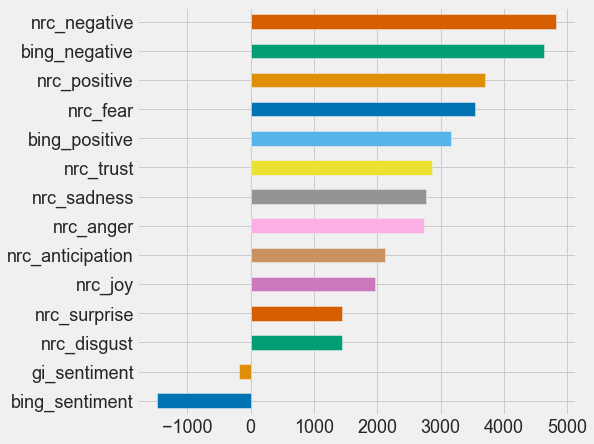

In [109]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [110]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [111]:
B.head()

,x
emo,
nrc_anger,"[[49], [124], [309], [391], [398], [420], [545..."
nrc_anticipation,"[[154], [206], [278], [429], [506], [537], [54..."
nrc_disgust,"[[49], [391], [420], [563], [633], [639], [659..."
nrc_fear,"[[49], [50], [124], [144], [154], [286], [385]..."
nrc_joy,"[[154], [206], [278], [429], [443], [451], [49..."


In [112]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

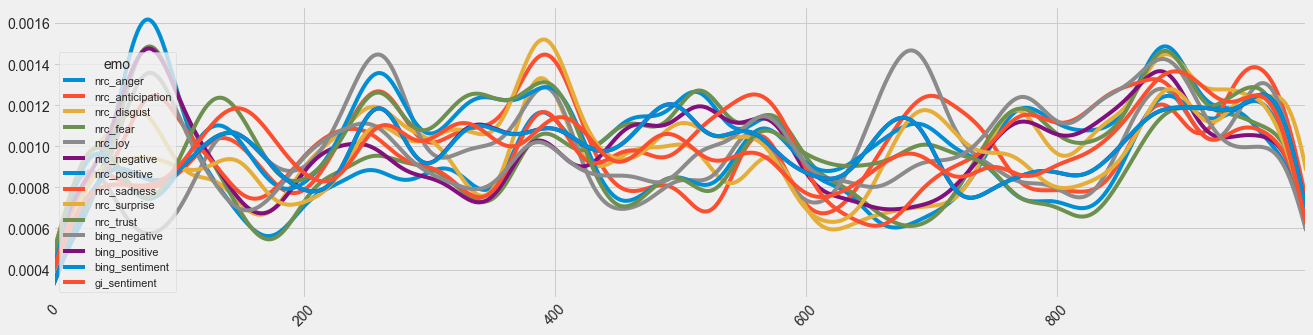

In [113]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

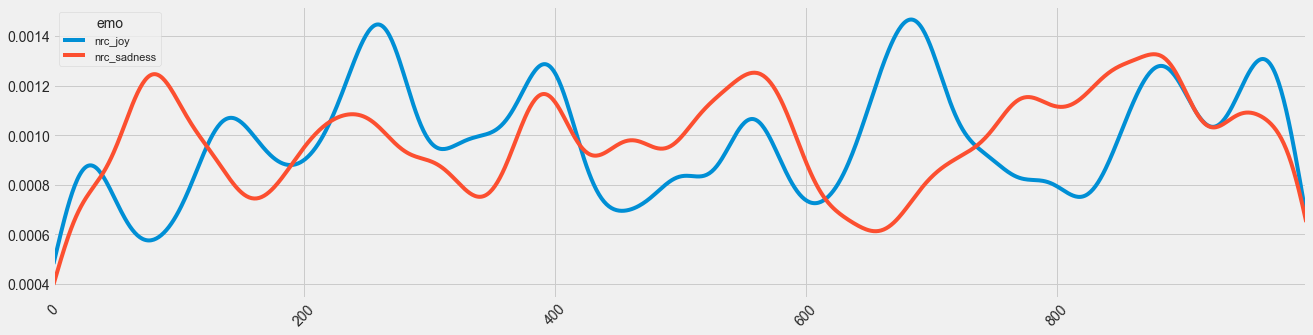

In [114]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

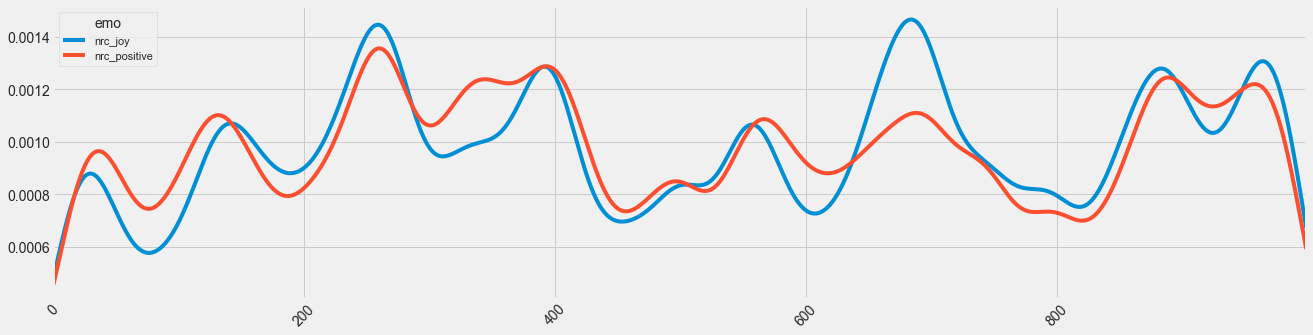

In [115]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

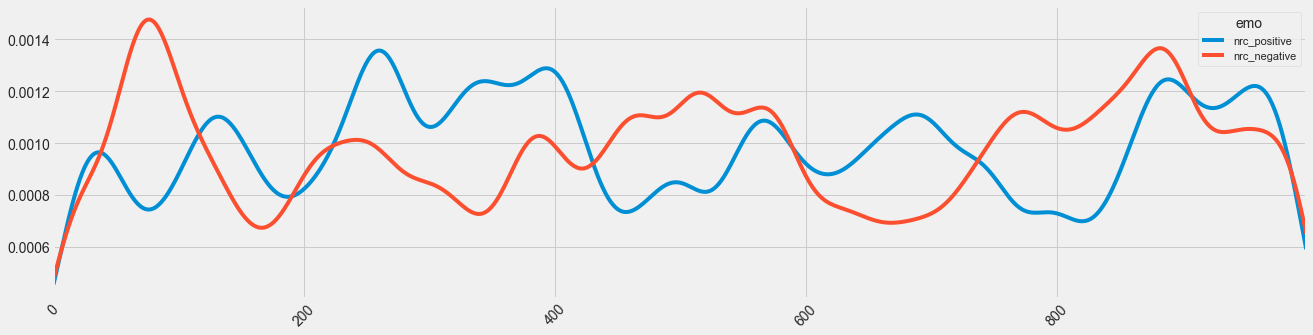

In [116]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

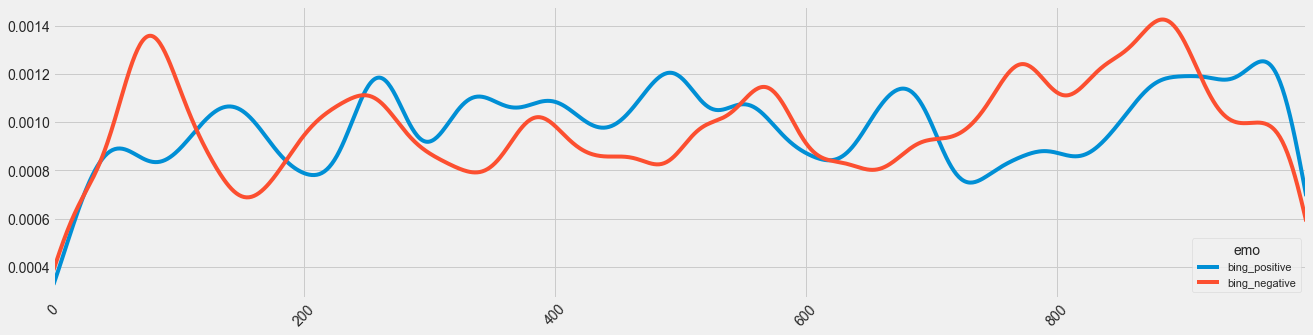

In [117]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)